# 03 - Data Exploration 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print(sys.version)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from tqdm.auto import tqdm

3.10.9 (main, Dec 19 2022, 17:35:49) [GCC 12.2.0]


In [3]:
sys.path.extend(["./SERVER/deployment/", "./SERVER/"])

In [4]:
from networks import LinearNetwork, VAENetwork, SACModel

### Load checkpoints 

In [5]:
DATA_ROOT = Path('./SERVER/checkpoints/')
DATA_ROOT = Path('./DATA/DEPLOYMENT/checkpoints/')

In [6]:
checkpoints = sorted(DATA_ROOT.glob("*.pth"))
print(len(checkpoints))

456


### Load models 

In [7]:
from server import embedder_params, decision_params, translator_params
from config import FEATURE_VECTOR_MAP, OUTPUT_VECTOR, OUTPUT_VECTOR_RANGES

3.10.9 (main, Dec 19 2022, 17:35:49) [GCC 12.2.0]
t_f 31, t_sr 4000


In [8]:
translator = SACModel(**translator_params)
embedder_network = VAENetwork(embedder_params, live_train=False)

### Interaction 

In [9]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [10]:
sliders = dict()
for feature in FEATURE_VECTOR_MAP:
    slider = widgets.FloatSlider(
        min=0.0, max=1.0, step=0.01, description=feature
    )
    sliders[feature] = slider

btn = widgets.Button(description="go!")
output = widgets.Output()

In [11]:
@btn.on_click
def go(b):
    step()

In [12]:
def step():
    data = torch.load(checkpoints[-1])
    translator.load(data["sac"])
    embedder_network.model.load_state_dict(data["embedder"])
    embedder_network.model.eval()
    
    x = torch.tensor([sliders[s].value for s in FEATURE_VECTOR_MAP])
    
    with torch.no_grad():
        z = embedder_network.model.encode(x).numpy()
        
    output.clear_output()
    with output:
        plt.scatter(z[0], z[1])
        plt.ylim(-0.5, 0.5)
        plt.xlim(-0.1, 0.1)
        plt.show()

In [13]:
for feature in FEATURE_VECTOR_MAP:
    display(sliders[feature])
display(btn)

FloatSlider(value=0.0, description='EEG:mean', max=1.0, step=0.01)

FloatSlider(value=0.0, description='EEG:delta', max=1.0, step=0.01)

FloatSlider(value=0.0, description='EOG:all_rate', max=1.0, step=0.01)

FloatSlider(value=0.0, description='EOG:p_rate', max=1.0, step=0.01)

FloatSlider(value=0.0, description='EOG:n_rate', max=1.0, step=0.01)

FloatSlider(value=0.0, description='GSR:mean', max=1.0, step=0.01)

FloatSlider(value=0.0, description='GSR:delta', max=1.0, step=0.01)

FloatSlider(value=0.0, description='heart:std', max=1.0, step=0.01)

Button(description='go!', style=ButtonStyle())

In [27]:
actions = []
target = np.array([0.0, 0.0])

for fp in checkpoints:
    data = torch.load(fp)
    translator.load(data["sac"])
    embedder_network.model.load_state_dict(data["embedder"])
    embedder_network.model.eval()

    translator.model.q_critic.eval()
    translator.model.actor.eval()

    x = torch.tensor([sliders[s].value for s in FEATURE_VECTOR_MAP])

    with torch.no_grad():
        z = embedder_network.model.encode(x).numpy()

    curr_state = np.concatenate([z, target])
    a = translator.get_action(curr_state, True)
    a = np.tanh(a * 5)
    
    actions.append(a)

actions = np.stack(actions)

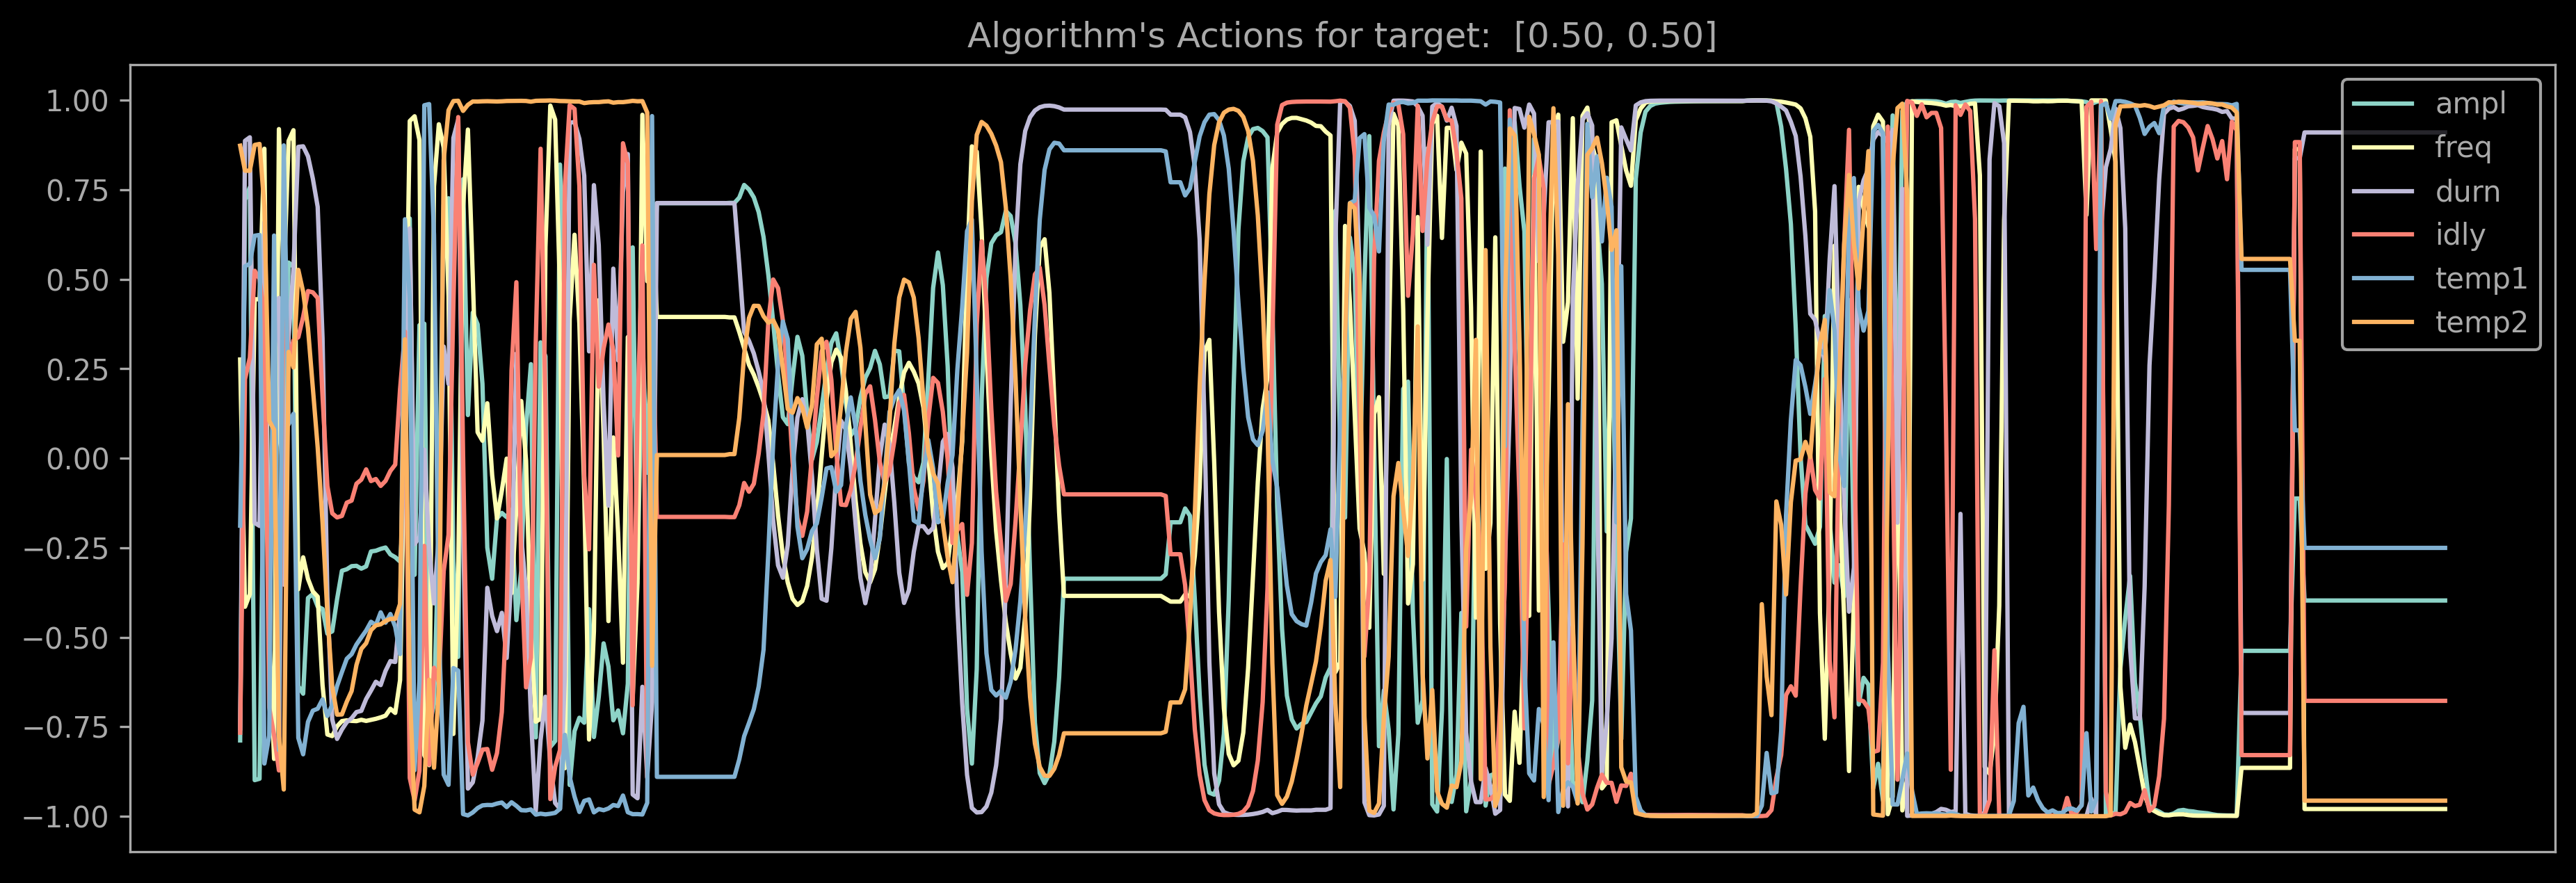

In [26]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
ax.set_xticks([])
for i in range(6):
    ax.plot(actions[:, i], label=OUTPUT_VECTOR[i]);

plt.title(f"Algorithm's Actions for target:  [{target[0]:.2f}, {target[1]:.2f}]")
plt.legend()
plt.show()